In [1]:
# Import libraries
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from glob import glob
import random
import numpy as np
from IPython.display import display
from datasets import load_dataset, Dataset, DatasetDict
from PIL import Image
from sklearn.model_selection import train_test_split
import albumentations as A

/opt/anaconda3/envs/comp4211/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
ds = load_dataset("EduardoPacheco/FoodSeg103")

In [3]:
# Separate splits to train and validation set
train_dataset = ds["train"]
val_dataset = ds["validation"]


def split_test_dataset(train_dataset, val_dataset, num_samples):
    # Ensure num_samples does not exceed the lengths of the datasets
    if num_samples > len(train_dataset) or num_samples > len(val_dataset):
        raise ValueError(
            "num_samples cannot exceed the number of entries in either dataset."
        )

    # Randomly sample from the training dataset
    sampled_train_indices = random.sample(range(len(train_dataset)), num_samples)
    test_from_train = train_dataset.select(sampled_train_indices)

    # Remove sampled entries from the training dataset
    remaining_train_indices = list(
        set(range(len(train_dataset))) - set(sampled_train_indices)
    )
    updated_train_dataset = train_dataset.select(remaining_train_indices)

    # Randomly sample from the validation dataset
    sampled_val_indices = random.sample(range(len(val_dataset)), num_samples)
    test_from_val = val_dataset.select(sampled_val_indices)

    # Remove sampled entries from the validation dataset
    remaining_val_indices = list(
        set(range(len(val_dataset))) - set(sampled_val_indices)
    )
    updated_val_dataset = val_dataset.select(remaining_val_indices)

    # Combine test datasets
    test_dataset = Dataset.from_dict(
        {
            "image": test_from_train["image"] + test_from_val["image"],
            "label": test_from_train["label"] + test_from_val["label"],
            "classes_on_image": test_from_train["classes_on_image"]
            + test_from_val["classes_on_image"],
            "id": test_from_train["id"] + test_from_val["id"],
        }
    )

    return updated_train_dataset, updated_val_dataset, test_dataset


# Example usage
num_samples = 100  # Number of samples to extract from each dataset
train_dataset, val_dataset, test_dataset = split_test_dataset(
    train_dataset, val_dataset, num_samples
)

In [4]:
# Get dataset information
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 4983
    })
    validation: Dataset({
        features: ['image', 'label', 'classes_on_image', 'id'],
        num_rows: 2135
    })
})


In [5]:
ingredients = np.array(
    [
        "background",
        "candy",
        "egg tart",
        "french fries",
        "chocolate",
        "biscuit",
        "popcorn",
        "pudding",
        "ice cream",
        "cheese butter",
        "cake",
        "wine",
        "milkshake",
        "coffee",
        "juice",
        "milk",
        "tea",
        "almond",
        "red beans",
        "cashew",
        "dried cranberries",
        "soy",
        "walnut",
        "peanut",
        "egg",
        "apple",
        "date",
        "apricot",
        "avocado",
        "banana",
        "strawberry",
        "cherry",
        "blueberry",
        "raspberry",
        "mango",
        "olives",
        "peach",
        "lemon",
        "pear",
        "fig",
        "pineapple",
        "grape",
        "kiwi",
        "melon",
        "orange",
        "watermelon",
        "steak",
        "pork",
        "chicken duck",
        "sausage",
        "fried meat",
        "lamb",
        "sauce",
        "crab",
        "fish",
        "shellfish",
        "shrimp",
        "soup",
        "bread",
        "corn",
        "hamburg",
        "pizza",
        "hanamaki baozi",
        "wonton dumplings",
        "pasta",
        "noodles",
        "rice",
        "pie",
        "tofu",
        "eggplant",
        "potato",
        "garlic",
        "cauliflower",
        "tomato",
        "kelp",
        "seaweed",
        "spring onion",
        "rape",
        "ginger",
        "okra",
        "lettuce",
        "pumpkin",
        "cucumber",
        "white radish",
        "carrot",
        "asparagus",
        "bamboo shoots",
        "broccoli",
        "celery stick",
        "cilantro mint",
        "snow peas",
        "cabbage",
        "bean sprouts",
        "onion",
        "pepper",
        "green beans",
        "French beans",
        "king oyster mushroom",
        "shiitake",
        "enoki mushroom",
        "oyster mushroom",
        "white button mushroom",
        "salad",
        "other ingredients",
    ]
)

Shape of training dataset: (4883, 4) 
Shape of validation dataset: (2035, 4)
Shape of test dataset: (200, 4)


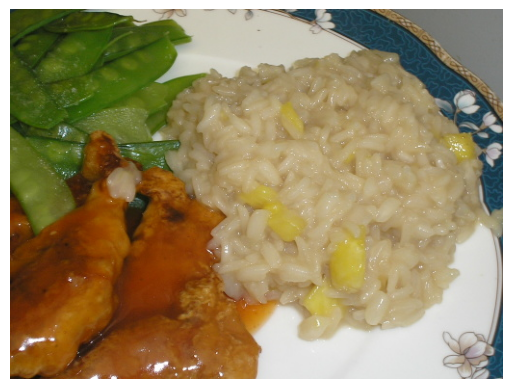

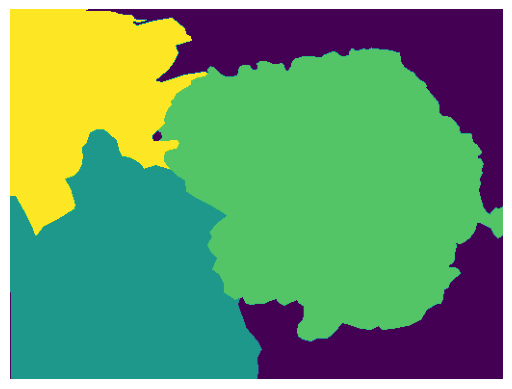

background
chicken duck
rice
snow peas


In [6]:
# Print sample items from dataset
print(
    f"Shape of training dataset: {train_dataset.shape} \nShape of validation dataset: {val_dataset.shape}\nShape of test dataset: {test_dataset.shape}"
)
# print(train_dataset[0]["id"])
# print(train_dataset[0]["image"])
# Display the image
image = train_dataset[0]["image"]
plt.imshow(image)
plt.axis("off")  # Turn off axis labels
plt.show()

# Display the label
label = train_dataset[0]["label"]
plt.imshow(label)
plt.axis("off")  # Turn off axis labels
plt.show()

# Print ingredient name according to the label
for index in train_dataset[0]["classes_on_image"]:
    if index < len(ingredients):
        print(ingredients[index])

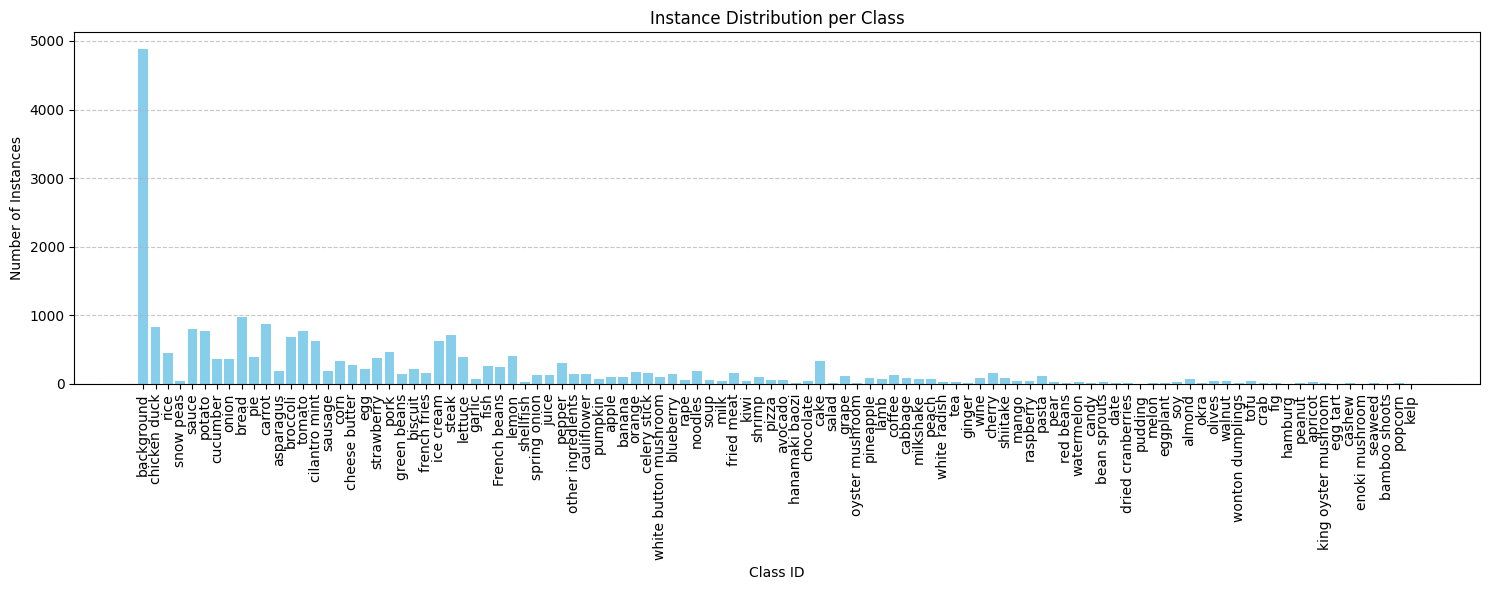

Class Distribution Summary:
           Class ID  Count
0        background   4882
1      chicken duck    832
2              rice    453
3         snow peas     47
4             sauce    800
..              ...    ...
99   enoki mushroom      6
100         seaweed      7
101   bamboo shoots      3
102         popcorn      9
103            kelp      1

[104 rows x 2 columns]


In [7]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Check if the labels directory exists
if not ds:
    print("Database is not loaded!")
else:
    # Counter for class occurrences
    class_counter = Counter()

    # Iterate over each train item to add to counter
    for item in train_dataset:
        for class_id in item["classes_on_image"]:
            class_counter[ingredients[class_id]] += 1
    # Plotting the distribution
    classes, counts = zip(*(class_counter.items()))

    plt.figure(figsize=(15, 6))
    plt.bar(classes, counts, color="skyblue")
    plt.xlabel("Class ID")
    plt.ylabel("Number of Instances")
    plt.title("Instance Distribution per Class")
    plt.xticks(rotation=90)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

class_summary = [
    {"Class ID": class_id, "Count": count} for class_id, count in class_counter.items()
]
class_summary_df = pd.DataFrame(class_summary)
print("Class Distribution Summary:")
print(class_summary_df)

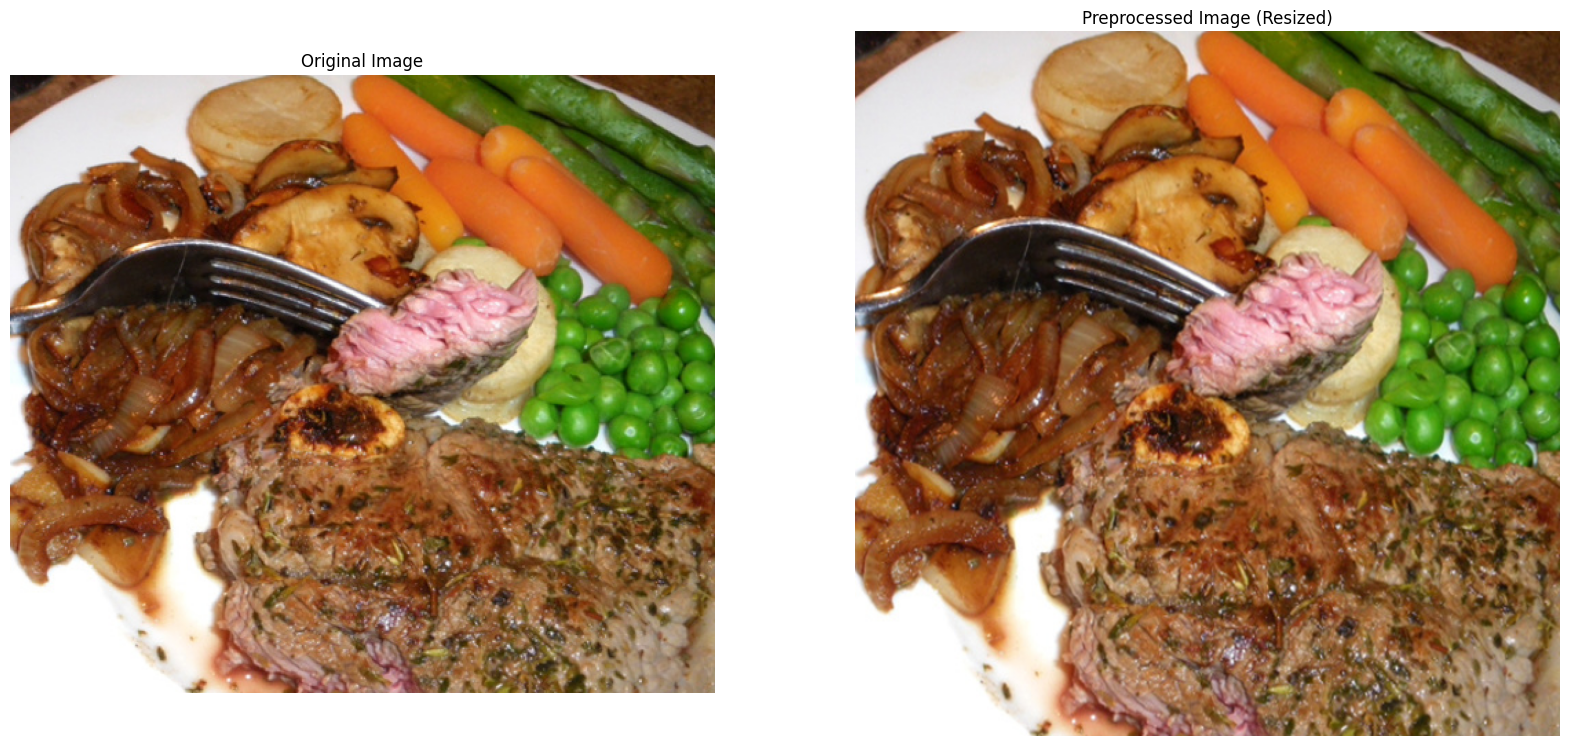

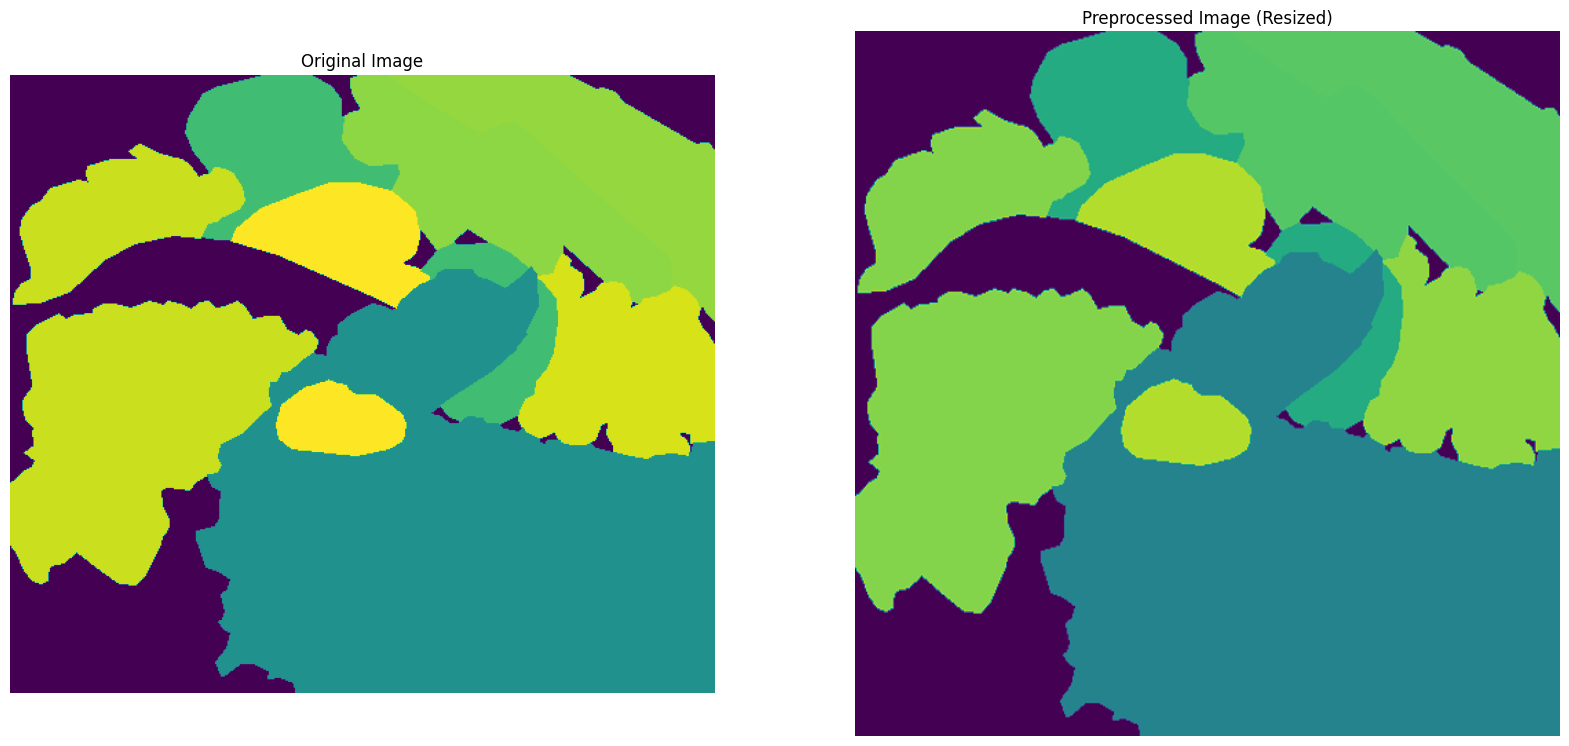

In [8]:
def preprocess_image(original_image, size=(640, 640)):
    # Resize image
    preprocessed_image = original_image.resize(size)

    # Convert to NumPy array
    preprocessed_image = np.array(preprocessed_image)

    # Normalize image
    preprocessed_image = preprocessed_image / 255.0  # Scale to [0, 1]
    return original_image, preprocessed_image


def preprocess_mask(original_mask, size=(640, 640)):
    # Resize mask
    preprocessed_mask = original_mask.resize(size)  # Use nearest for masks

    # Convert to NumPy array
    preprocessed_mask = np.array(preprocessed_mask)

    # Normalize image
    preprocessed_mask = preprocessed_mask / 255.0  # Scale to [0, 1]

    return original_mask, preprocessed_mask


def plot_preprocessing_comparison(image, mask=False):
    if mask:
        original, preprocessed = preprocess_mask(image)
    else:
        original, preprocessed = preprocess_image(image)

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed)
    plt.title("Preprocessed Image (Resized)")
    plt.axis("off")

    plt.show()


# Visualize preprocessing on a random training image
sample = random.choice(train_dataset)
plot_preprocessing_comparison(sample["image"])
plot_preprocessing_comparison(sample["label"], mask=True)

/opt/anaconda3/envs/comp4211/lib/python3.12/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


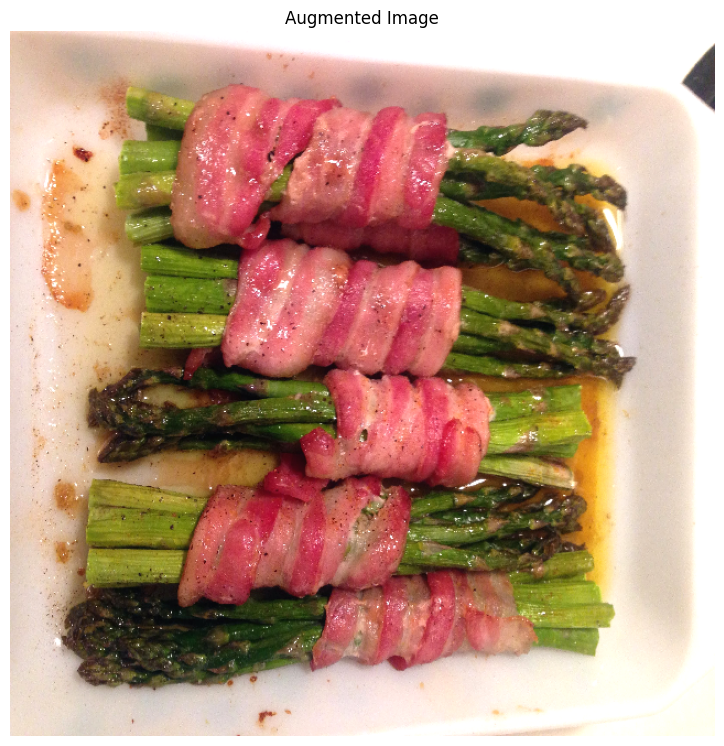

In [9]:
# Add data augmentation
# Define data augmentation transformations
import albumentations as A


def random_data_augmentation(image, mask=None):
    # Define the augmentation pipeline
    augmentation = A.Compose(
        [
            A.HorizontalFlip(p=0.5),  # Flip images horizontally
            A.VerticalFlip(p=0.5),  # Flip images vertically
            A.RandomRotate90(p=0.5),  # Rotate images by 90 degrees
            A.RandomBrightnessContrast(
                brightness_limit=0.25,  # Limits for brightness adjustment
                contrast_limit=0.2,  # Limits for contrast adjustment
                p=0.5,  # Apply with a probability of 0.5
            ),
            A.ShiftScaleRotate(
                shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5
            ),
            A.Resize(height=640, width=640),  # Resize images
            A.Normalize(
                mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)
            ),  # Normalizing to [0, 1]
        ],
        p=1.0,
    )  # Apply all augmentations with a probability of 1.0

    # Apply the augmentations
    if mask is not None:
        augmented = augmentation(image=image, mask=mask)
        return augmented["image"], augmented["mask"]
    else:
        augmented = augmentation(image=image)
        return augmented["image"]


def show_random_data_augmentation(ds):
    # Sample random image and mask from your dataset
    sample = random.choice(ds)
    image = np.array(sample["image"])  # Convert PIL to NumPy array
    mask = np.array(sample["label"])  # Convert mask to NumPy array if available

    # Apply random data augmentation
    # augmented_image, augmented_mask = random_data_augmentation(image, mask)
    augmented_image = random_data_augmentation(image)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title("Augmented Image")
    plt.imshow(augmented_image)
    plt.axis("off")

    plt.show()


show_random_data_augmentation(train_dataset)

In [10]:
# # Perform data preprocessing on training dataset
# def perform_preprocessing(dataset, augmentations=True):
#     new_images = []
#     new_labels = []

#     for entry in dataset:
#         original_image = entry["image"]
#         original_label = entry["label"]

#         # Preprocess the image and mask
#         original_image, preprocessed_image = preprocess_image(original_image)
#         original_label, preprocessed_mask = preprocess_mask(original_label)

#         # Add original image and mask to the augmented lists
#         new_images.append(preprocessed_image)
#         new_labels.append(preprocessed_mask)

#         # If augmentations are enabled, apply them
#         # if augmentations:
#         #     for _ in range(3):  # Generate 3 augmented versions of each image
#         aug_image, aug_mask = random_data_augmentation(
#             preprocessed_image, preprocessed_mask
#         )
#         new_images.append(aug_image)
#         new_labels.append(aug_mask)

#     # Convert lists to numpy arrays
#     new_images = np.array(new_images)
#     new_labels = np.array(new_labels)

#     return new_images, new_labels


# train_dataset_preprocessed, train_dataset_preprocessed = perform_preprocessing(
#     train_dataset, augmentations=False
# )
# print(f"Shape of augmented images: {train_dataset_preprocessed.shape}")

# val_dataset_preprocessed, val_dataset_preprocessed = perform_preprocessing(
#     val_dataset, augmentations=False
# )
# print(f"Shape of augmented images: {val_dataset_preprocessed.shape}")

# test_dataset_preprocessed, test_dataset_preprocessed = perform_preprocessing(
#     test_dataset, augmentations=False
# )